In [1]:
import numpy as np
import pandas as pd
import math as m
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## Notebook: series de tiempo de riñas en Bogotá 2014 -2019
>#### Autores: Jorge Victorino - Miguel Barrero
>#### Conjunto de datos: Nuse 2014-2019

#### 1. Carga de los datos  

In [2]:
# lectura de los datos
short = pd.read_csv('../dataNuse/short.csv', sep=',', encoding='utf-8', error_bad_lines=False)
nuse1 = pd.read_csv('../dataNuse/nuse_110220.csv', sep=',', encoding='utf-8', error_bad_lines=False)

/home/mike/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### 2. Filtrado de los datos.
> Los datos que se tienen en cuenta en un filtrado inicial son aquellos que tienen códigos de UPZ válidos.

##### 2.1 Función de filtrado
> Parámetros: (df) : datataframe original  de Nuse

In [3]:
# agregación de columnas y filtrado de los datos nulos
def data_crime(df):
    # filtrado de los datos
    dfo = df[['LONGITUD', 'LATITUD', 'LOCALIDAD', 'COD_UPZ', 'UPZ', 
              'FECHA','MES','ANIO']].sort_values(by=['COD_UPZ'])
    dfo = dfo[((dfo['COD_UPZ'] !=  'ND')  & (dfo['COD_UPZ']  != 'UPZ999'))]
    dfo.reset_index(inplace=True)
    dfo = dfo.rename(columns={'index':'INDEX_TIME'})
    
    # generando nuevas columnas
    dfo['JORN'] = pd.to_datetime(dfo['FECHA']).dt.hour//6
    dfo['DIA'] = pd.to_datetime(dfo['FECHA']).dt.day
    dfo['DSEM'] = pd.to_datetime(dfo['FECHA']).dt.dayofweek
    dfo['ESDIA'] = [0 if (x==0 or x==3) else 1 for x in dfo['JORN']]
    dfo['NSEM'] = pd.to_datetime(dfo['FECHA']).dt.week
    dfo['FSEM'] = [0 if x<4 else 1 for x in dfo['DSEM']]
    return dfo
   

#### 3. Generación del conjunto de datos.
> Las series de tiempo para la predicción del crimen podrán ser agrupadas y generadas para los años del 2014 a 2019. Las series de tiempo pueden darse en periodos:
* Menusales
* Semanales
* Diarios
* Para un día en específico de la semana (lunes, martes, miércoles, jueves, viernes)
* Para una jornada en específico y día de la semana en específico (martes en la madrugada)
* Para una jornada, todos los días (Lunes a Domingo en la tarde)
* Semanal entre semana (Lunes a Jueves)
* Semanal fines de semana (Viernes a Domingo)

##### 3.1 Funciones para generar el conjunto de datos.
> Existen dos funciones:
1. **data_series:** genera los datos para series de tiempo en los periodos anteriormente mencionados.
2. **st_series:** filtra los datos a partir de un punto espacial de interés y genera el conjunto de datos para la serie de tiempo dependiendo del periodo seleccionado.

La función **bw_intervals** encuentra los incidentes a lo largo del conjunto de datos que se encuentran dentro de una área circular alrededor del punto de interés.

##### 3.1.1 Función data_series

A continuación se especifican los parámetros de la función:

Parámetro | Descripción
:--------: | -------
fi | Año inicial para el conjunto de datos. Año de inicio de la serie de tiempo.
ff | Año final para el conjunto de datos. Año de fin de la serie de tiempo.
df | Dataframe filtardo de la función data_crime. 
tp | Tipo de serie de tiempo. Puede ser : mensual = 0, semanal = 1, diario = 2, día de la semana = 3, jornada (en un día de la semana) = 4, una jornada todos los días = 5, entre semana = 6, fines de semana = 7
ds | Día de la semana para la serie de tiempo. Permitido de 0 a 6, donde 0 es lunes y 6 es domingo.
jd | Jornada del día. Permitido de 0 a 3. 
 

In [330]:
x, y = data_series('2014', '2020',dfp, 1, 1, 3)

mes = pd.date_range(start='2014', end='2020', freq='W', closed="right").strftime('%Y-%m-%d')
mes[0:52]
#(pd.to_datetime(mes[0]) + pd.to_timedelta(1,'d')).strftime('%Y-%m-%d')

dfp = dfp.sort_values(['FECHA'])
b = dfp[(dfp['FECHA'] >= '2019-11-18') & (dfp['FECHA'] < '2019-11-25')]
#b = dfp[(dfp['FECHA'] <= '2014-01-06')]
len(b)
#pd.to_datetime('2015').strftime('%Y-%m-%d')

6783

In [362]:
x[290:]

,ANIO,NSEM,EVENTS
2019-07-28,2019,30,6284
2019-08-04,2019,31,6916
2019-08-11,2019,32,7110
2019-08-18,2019,33,6749
2019-08-25,2019,34,6955
2019-09-01,2019,35,6603
2019-09-08,2019,36,7119
2019-09-15,2019,37,6936
2019-09-22,2019,38,7164
2019-09-29,2019,39,6645


In [345]:
# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5, entre semana = 6, fines de semana = 7

# parámetros: fi: fecha de inicio, ff: fecha final, df: dataframe, 
#             tp: tipo de serie, ds: día de la semana,
#             jd: jornada en un día específico.
def data_series(fi, ff, df, tp, ds, jd):
    
    dfi, dfo = None, None
    index, serie = list(), list()
    
    if tp >= 0 and tp <= 7:
        # mensual
        if tp == 0:
            # indice para todos los meses
            index = pd.date_range(start=fi, end=ff, freq='M', 
                                  closed="left").strftime('%Y-%m').to_list()     
            # agrupando por
            serie = ['ANIO', 'MES']
            # preparando dataframe de salida
            data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}
            dfo = pd.DataFrame(index=index, data=data)
            
            # agrupación por año y mes
            dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
            dfi['FECHA'] = pd.to_datetime(dfi['ANIO'].astype(str) + 
                                          '-' + dfi['MES'].astype(str)).dt.strftime('%Y-%m')
            
            for i in range(len(dfi)):
                if dfo.index[i] == dfi['FECHA'].iloc[i]:
                    dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
            return dfo
        # semanal
        if tp == 1:
            # indice para todas las semanas
            index = pd.date_range(start=fi, end=ff, freq='W', 
                                  closed="left").strftime('%Y-%m-%d').to_list()
            # agrupando por
            serie = ['ANIO', 'MES', 'NSEM']
            data = {'ANIO': pd.to_datetime(index).year.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}
            # preparando dataframe de salida
            #dfo = pd.DataFrame(index=index.to_list(), data=data)
            dfo = pd.DataFrame(index=index, data=data)
            dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index() 
            anios = int(ff) - int(fi)
            vt = 0
            for i in range(len(dfo)):
                ao = dfo['ANIO'].iloc[i]
                so = dfo['NSEM'].iloc[i]
                
                if so == 52 or so == 53:
                    f = pd.to_datetime(dfo.index[i]) - pd.to_timedelta(7,'d')
                    dsem = f.dayofweek
                    if dsem == 6 and f.year == pd.to_datetime(dfo.index[i]).year:
                        
                        d = dfi[(dfi['ANIO'] == pd.to_datetime(dfo.index[i]).year) & (dfi['NSEM'] == so)]
                        if pd.to_datetime(dfo.index[i]).month == 12 and len(d) == 2 and so == 52:
                            dfo['EVENTS'].iloc[i] = d['UPZ'].iloc[1]
                        
                        else:
                            dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
                    else:
                        d = dfi[((dfi['ANIO'] == f.year) | (dfi['ANIO'] == pd.to_datetime(dfo.index[i]).year)) & (dfi['NSEM'] == so)]
                        if pd.to_datetime(dfo.index[i]).month == 1 and len(d) == 3 and so == 52:
                            dfo['EVENTS'].iloc[i] = d['UPZ'].iloc[0] + d['UPZ'].iloc[1]
                               
                        else:
                            dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
                            
                if so == 1 and pd.to_datetime(dfo.index[i]).year != int(fi):
                    f = pd.to_datetime(dfo.index[i]) - pd.to_timedelta(7,'d')
                    dsem = f.dayofweek
                    if dsem == 6 and f.year == pd.to_datetime(dfo.index[i]).year:
                        dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
                    else:
                        d = dfi[((dfi['ANIO'] == f.year) | (dfi['ANIO'] == pd.to_datetime(dfo.index[i]).year)) & (dfi['NSEM'] == so)]
                        dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
                
                if so == 1 and pd.to_datetime(dfo.index[i]).year == int(fi) and i == 0:
                
                    d = dfi[(dfi['ANIO'] == int(fi)) & (dfi['MES'] == 1) & (dfi['NSEM'] == 1)]
                    dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
                
                if so != 52 and so != 53 and i != 0:
                    
                    if so == 1 and pd.to_datetime(dfo.index[i - 1]).week != 52 and pd.to_datetime(dfo.index[i - 1]).week != 53:
                        fia = pd.to_datetime(dfo.index[i]).dayofweek
                        f = pd.to_datetime(dfo.index[i]) - pd.to_timedelta(6,'d')
                        dsem = f.dayofweek
                        if dsem == 0 and f.year == pd.to_datetime(dfo.index[i]).year:
                            d = dfi[(dfi['ANIO'] == ao) & (dfi['NSEM'] == so)]
                            dfo['EVENTS'].iloc[i] = d['UPZ'].iloc[0]
                        else:
                            f = pd.to_datetime(dfo.index[i]) - pd.to_timedelta(6,'d')
                            if f.year != pd.to_datetime(dfo.index[i]).year:
                                d = dfi[((dfi['ANIO'] == f.year) | (dfi['ANIO'] == pd.to_datetime(dfo.index[i]).year)) & (dfi['NSEM'] == so)]
                                print(d)
                                dfo['EVENTS'].iloc[i] = d['UPZ'].iloc[1] + d['UPZ'].iloc[2]
                    else:
                        d = dfi[(dfi['ANIO'] == ao) & (dfi['NSEM'] == so)]
                        dfo['EVENTS'].iloc[i] = d['UPZ'].sum()
            return dfo
        # diario
        if tp == 2:
            # indice para todos los días
            index = pd.date_range(start=fi, end=ff, freq='D', 
                                 closed="left").strftime('%Y-%m-%d').to_list()
            # agrupando por
            serie = ['ANIO', 'MES', 'DIA']
            # preparando dataframe de salida
            data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'DIA': pd.to_datetime(index).day.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)} 
            dfo = pd.DataFrame(index=index, data=data)
            # generando agrupamiento
            dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()    
            dfi['FECHA'] = pd.to_datetime(dfi['ANIO'].astype(str) + 
                                          '-' + dfi['MES'].astype(str) + 
                                          '-' + dfi['DIA'].astype(str)).dt.strftime('%Y-%m-%d')
            for i in range(len(dfi)):
                if dfo.index[i] == dfi['FECHA'].iloc[i]:
                    dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
            return dfo
        # día de la semana
        if tp == 3 and ds != None:
            # lunes 0 - domingo 6
            if ds >= 0 and ds <= 6:
                # índice de todos los días
                index = pd.date_range(start=fi, end=ff, freq='D', 
                                     closed="left").strftime('%Y-%m-%d')
                # índice con solo un día en específico (l, m, mi, j, v, s, d)
                index = index[pd.to_datetime(index).dayofweek == ds].to_list()
                # agrupando por
                serie = ['ANIO','MES','NSEM', 'DSEM']
                # preparando dataframe de salida
                data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'DSEM': pd.to_datetime(index).dayofweek.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}     
                dfo = pd.DataFrame(index=index, data=data)
                # generando agrupamiento
                dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
                dfi = dfi[dfi['DSEM'] == ds]
                
                for i in range(len(dfi)):
                    if (dfo['ANIO'].iloc[i] == dfi['ANIO'].iloc[i]) and (dfo['MES'].iloc[i] == dfi['MES'].iloc[i]) and (dfo['NSEM'].iloc[i] == dfi['NSEM'].iloc[i]) and (dfo['DSEM'].iloc[i] == dfi['DSEM'].iloc[i]):
                            dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
                return dfo
        
        # día de la semana y jornada
        if tp == 4 and ds != None and jd != None:
            
            if (ds >= 0 and ds <= 6) and (jd >= 0 and jd <= 3):
                
                index = pd.date_range(start=fi, end=ff, freq='D', 
                                     closed="left").strftime('%Y-%m-%d')
                # índice con solo un día en específico (l, m, mi, j, v, s, d)
                index = index[pd.to_datetime(index).dayofweek == ds].to_list()
                # agrupando por
                serie =  ['ANIO','MES','NSEM', 'DSEM', 'JORN']
                # preparando dataframe de salida
                data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'DSEM': pd.to_datetime(index).dayofweek.tolist(),
                    'JORN': np.full(len(index), jd, dtype=int),   
                    'EVENTS': np.zeros(len(index), dtype=int)}     
                dfo = pd.DataFrame(index=index, data=data)
                # generando agrupamiento
                dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
                dfi = dfi[(dfi['DSEM'] == ds) & (dfi['JORN'] == jd)]
                
                for i in range(len(dfi)):
                    if (dfo['ANIO'].iloc[i] == dfi['ANIO'].iloc[i]) and (dfo['MES'].iloc[i] == dfi['MES'].iloc[i]) and (dfo['NSEM'].iloc[i] == dfi['NSEM'].iloc[i]) and (dfo['DSEM'].iloc[i] == dfi['DSEM'].iloc[i]) and (dfo['JORN'].iloc[i] == dfi['JORN'].iloc[i]): 
                            dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
                return dfo
        # todas las jornadas todos los días
        if tp == 5 and jd != None:
            
            if jd >= 0 and jd <= 3:
                # índice para todos los días cada 6 horas 
                index = pd.date_range(start=fi, end=ff, freq='6H',
                                      closed="left").strftime('%Y-%m-%d %H').to_list()
                # agrupando por
                serie = ['ANIO','MES','NSEM', 'DSEM', 'JORN']
                # preparando dataframe de salida
                data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'MES': pd.to_datetime(index).month.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'DSEM': pd.to_datetime(index).dayofweek.tolist(),
                    'JORN': pd.to_datetime(index).hour//6,   
                    'EVENTS': np.zeros(len(index), dtype=int)}     
                dfo = pd.DataFrame(index=index, data=data)
                # generando agrupamiento
                dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
                
                for i in range(len(dfi)):
                    if (dfo['ANIO'].iloc[i] == dfi['ANIO'].iloc[i]) and (dfo['MES'].iloc[i] == dfi['MES'].iloc[i]) and (dfo['NSEM'].iloc[i] == dfi['NSEM'].iloc[i]) and (dfo['DSEM'].iloc[i] == dfi['DSEM'].iloc[i]) and (dfo['JORN'].iloc[i] == dfi['JORN'].iloc[i]): 
                            dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
                return dfo
        # semanas de lunes a jueves
        if tp == 6:
            # índice para semanas de lunes a jueves          
            index = pd.date_range(start=fi, end=ff, freq='W-THU',
                                      closed="left").strftime('%Y-%m-%d').to_list()
            # agrupando por
            serie = ['ANIO','NSEM']
            # preparando dataframe de salida
            data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}     
            dfo = pd.DataFrame(index=index, data=data)
            # filtro días de lunes a jueves
            dfi = df[df['DSEM'] <= 3]
             # generando agrupamiento
            dfi = pd.DataFrame(dfi.groupby(serie)['UPZ'].count()).reset_index()
            for i in range(len(dfi)):
                if dfo['ANIO'].iloc[i] == dfi['ANIO'].iloc[i] and dfo['NSEM'].iloc[i] == dfi['NSEM'].iloc[i]:
                    dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
            return dfo
        if tp == 7:
            # índice para semanas de viernes a domingo
            index = pd.date_range(start=fi, end=ff, freq='D',
                                      closed="left").strftime('%Y-%m-%d')
            index = index[pd.to_datetime(index).dayofweek == 6]
            # agrupando por
            serie = ['ANIO','NSEM']
            # preparando dataframe de salida
            data = {'ANIO': pd.to_datetime(index).year.tolist(), 
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}     
            dfo = pd.DataFrame(index=index.to_list(), data=data)
            # filtro días de lunes a jueves
            dfi = df[(df['DSEM'] > 3) & (df['DSEM'] <= 6)]
             # generando agrupamiento
            dfi = pd.DataFrame(dfi.groupby(serie)['UPZ'].count()).reset_index()
            for i in range(len(dfi)):
                if dfo['ANIO'].iloc[i] == dfi['ANIO'].iloc[i] and dfo['NSEM'].iloc[i] == dfi['NSEM'].iloc[i]:
                    dfo['EVENTS'].iloc[i] = dfi['UPZ'].iloc[i]
            return dfo
            

In [5]:
# encontra intervalos ancho de banda
def bw_intervals(mts, long, lat):
    
    lt_min, lt_max, lg_min, lg_max = 0, 0, 0, 0
    
    cearth = 40075           # earth circumference in kmss
    onedeg_km = cearth / 360 # 1 degree to kms 
    mt_km = mts / 1000       # mts to kms
    
    deglt = mt_km / onedeg_km              # convert kms to deglat
    deglg = mt_km / m.cos(m.radians(lat))  # convert kms to deglong
        
    if lat < 0:
        
        lt_min = -deglt + lat 
        lt_max = lat + deglt
    else:
        
        lt_min = lat - deglt   
        lt_max = lat + deglt
    
    if long < 0:
        
        lg_min = -deglg + long
        lg_max = long + deglg
    else:
        
        lg_min = long - deglt   
        lg_max = long + deglt
    
    return [lg_min, lg_max], [lt_min, lt_max] 

In [315]:
# Tipos de series de tiempo
# mensual = 0, semanal = 1, diario = 2, dia semana = 3, jornada (dia de la semana) = 4
# jornada todos los dias = 5, entre semana = 6, fines de semana = 7

# parámetros: fi: fecha de inicio, ff: fecha final, df: dataframe, 
#             tp: tipo de serie, ds: día de la semana,
#             jd: jornada en un día específico, mts: ancho de banda en metros
#             plg: valor longitud punto de interés, 
#             plt: valor de latitud punto de interés.
def st_series(fi, ff, df, tp, ds, jd, mts, plg, plt):
    
    # encontrando intervalos de ancho de banda
    bwlong, bwlat = bw_intervals(mts, plg, plt)
    # df.rename(columns={'Unnamed: 0': 'COUNT'}, inplace=True)
    # dataframe filtrado por latitud y longitud
    dff = df[((df['LATITUD'] >= bwlat[0]) & (df['LATITUD'] <= bwlat[1])) & 
             ((df['LONGITUD'] >= bwlong[0]) & (df['LONGITUD'] <= bwlong[1]))]

    # dataframe para la serie de tiempo de acuerdo al tipo
    # parámetros: df: dataframe, tp: tipo de serie, a: año, ds: día de la semana,
    #             jd: jornada en un día específico
    dffs = data_series(fi, ff, dff, tp, ds, jd)
    # return pd.DataFrame(columns=['COUNT'], data=dffg)
    return dffs

In [7]:
# adecuando el conjunto de datos (dataframe principal)
dfp = data_crime(nuse1)

In [355]:
#x = data_time_series(0, None, 1, 2, 100, -74.07745119017216, 4.604447520159951, dfp)
#z = st_series('2014', '2020',dfp, 1, 1, 3, 5000, -74.07745119017216, 4.604447520159951)
# BOSA dft z
z = st_series('2014', '2020',dfp, 0, 1, 3, 5000, -74.185244, 4.60905)

In [356]:
#z[z['EVENTS'] == 0] loess
z

,ANIO,MES,NSEM,DSEM,JORN,EVENTS
2014-01-07,2014,1,2,1,3,79
2014-01-14,2014,1,3,1,3,109
2014-01-21,2014,1,4,1,3,136
2014-01-28,2014,1,5,1,3,140
2014-02-04,2014,2,6,1,3,144
...,...,...,...,...,...,...
2019-12-03,2019,12,49,1,3,0
2019-12-10,2019,12,50,1,3,0
2019-12-17,2019,12,51,1,3,0
2019-12-24,2019,12,52,1,3,0


In [343]:
z = st_series('2014', '2020',dfp, 1, 1, 3, 1000, -74.185244, 4.60905)

In [138]:
q[q['ANIO'] == 2016]

,ANIO,MES,NSEM,UPZ
125,2016,1,1,1045
126,2016,1,2,663
127,2016,1,3,646
128,2016,1,4,705
129,2016,1,53,906
...,...,...,...,...
182,2016,12,48,453
183,2016,12,49,1027
184,2016,12,50,864
185,2016,12,51,1237


In [156]:
dfp

,INDEX_TIME,LONGITUD,LATITUD,LOCALIDAD,COD_UPZ,UPZ,FECHA,MES,ANIO,JORN,DIA,DSEM,ESDIA,NSEM,FSEM
68196,442299,-74.073169,4.616431,TEUSAQUILLO,UPZ101,TEUSAQUILLO,2015-10-07 10:02:16,10,2015,1,7,2,1,41,0
68199,442750,-74.073178,4.616754,TEUSAQUILLO,UPZ101,TEUSAQUILLO,2015-10-08 19:16:25,10,2015,3,8,3,0,41,0
68257,998502,-74.074000,4.617948,TEUSAQUILLO,UPZ101,TEUSAQUILLO,2014-08-23 14:47:58,8,2014,2,23,5,1,34,1
68272,2244885,-74.073178,4.616754,TEUSAQUILLO,UPZ101,TEUSAQUILLO,2018-02-07 01:33:10,2,2018,0,7,2,0,6,0
68274,1599049,-74.073169,4.616431,TEUSAQUILLO,UPZ101,TEUSAQUILLO,2015-10-10 12:47:57,10,2015,2,10,5,1,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155647,59208,-74.062726,4.600967,CANDELARIA,UPZ94,LA CANDELARIA,2015-02-08 04:57:41,2,2015,0,8,6,0,6,1
2155658,2136478,-74.065462,4.600113,CANDELARIA,UPZ94,LA CANDELARIA,2016-01-30 11:21:38,1,2016,1,30,5,1,4,1
2155661,1602224,-74.067070,4.602382,CANDELARIA,UPZ94,LA CANDELARIA,2015-12-07 12:47:29,12,2015,2,7,0,1,50,0
2155664,567499,-74.068965,4.600520,CANDELARIA,UPZ94,LA CANDELARIA,2019-08-26 16:49:12,8,2019,2,26,0,1,35,0


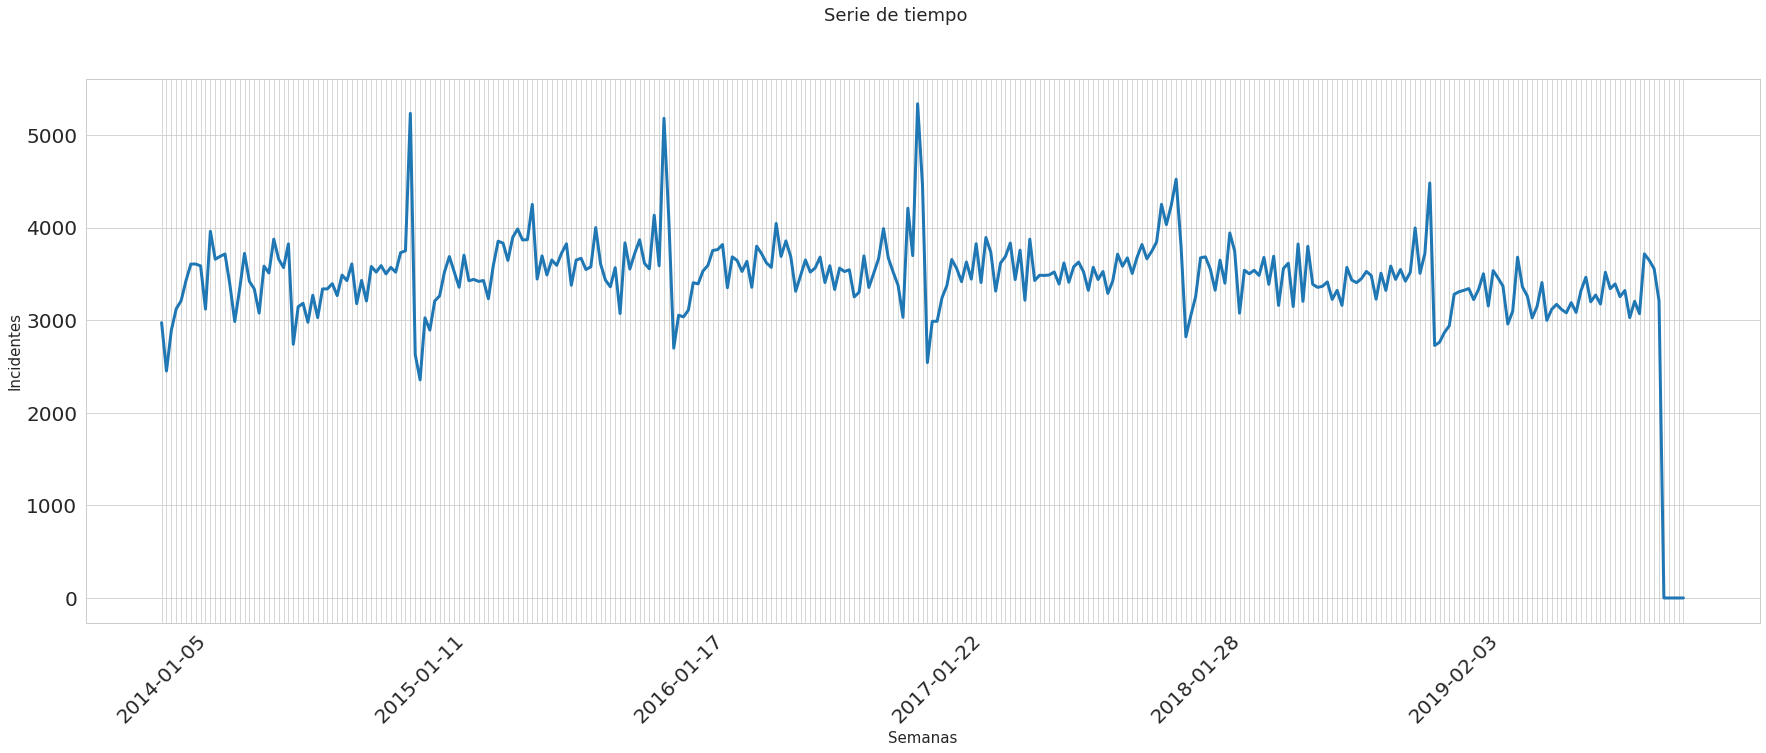

In [352]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=z, x=z.index, y='EVENTS', linewidth = 3)

for ind, label in enumerate(lp.get_xticklabels()):
    if ind % 53 == 0: 
        label.set_visible(True)
    else:
        label.set_visible(False)
#sns.scatterplot(data=z, x=z.index, y='EVENTS', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
plt.xticks(fontsize=20, rotation='45')
plt.yticks(fontsize=20)
#sns.despine()
plt.show()

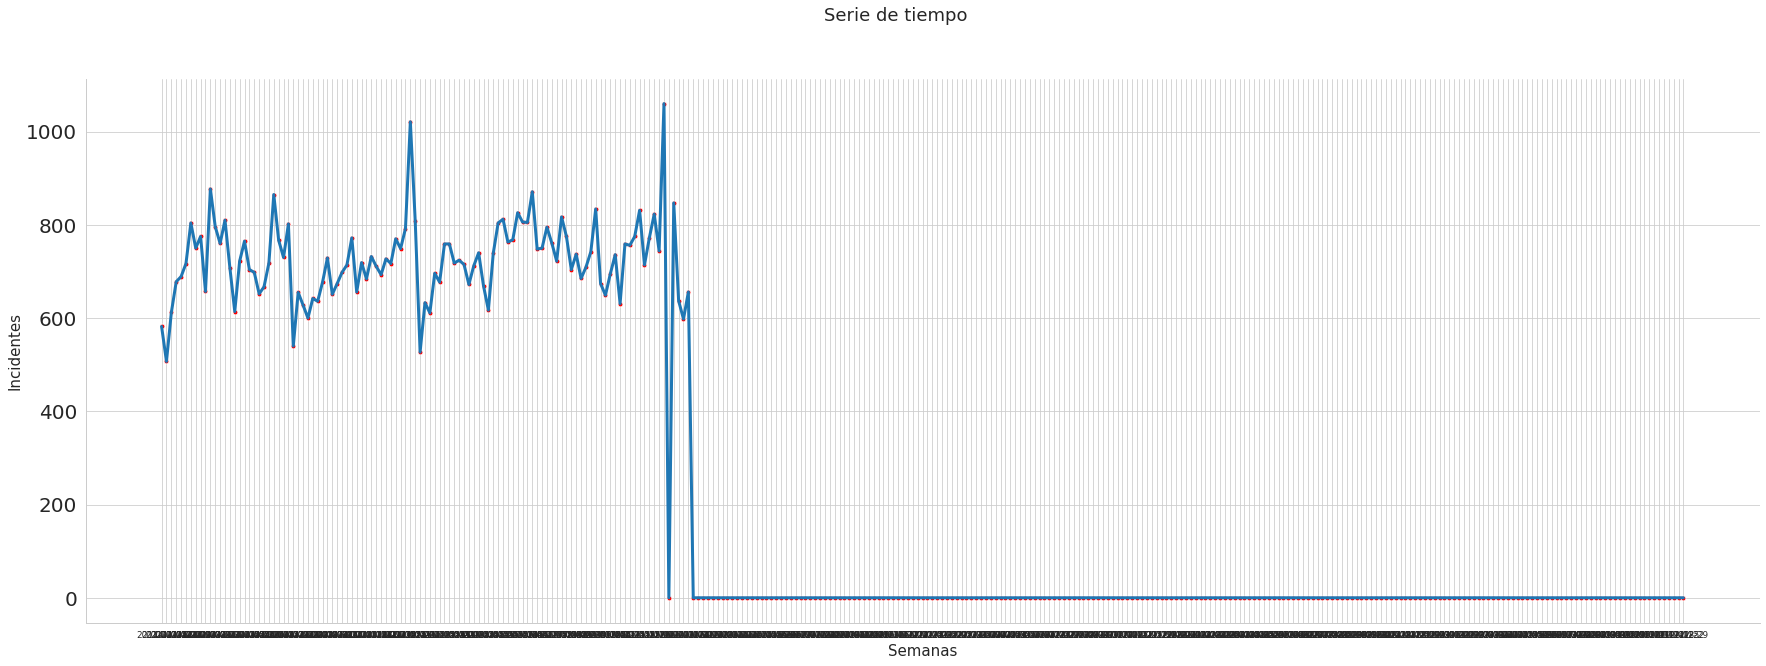

In [358]:
mes = pd.date_range(start='2014', end='2020', freq='M', closed="left").strftime('%Y-%m-%d')
offset.
mes
# otra forma de hacerlo
#df['DATE'] + pd.DateOffset(days=180)

Index(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
       '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
       '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
       '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
       '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
       '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
       '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
       '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
       '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
       '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
       '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
       '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
       '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',

In [201]:
pd.date_range(start='2014', end='2020', freq='6H', closed="left").strftime('%Y-%m-%d %H')

Index(['2014-01-01 00', '2014-01-01 06', '2014-01-01 12', '2014-01-01 18',
       '2014-01-02 00', '2014-01-02 06', '2014-01-02 12', '2014-01-02 18',
       '2014-01-03 00', '2014-01-03 06',
       ...
       '2019-12-29 12', '2019-12-29 18', '2019-12-30 00', '2019-12-30 06',
       '2019-12-30 12', '2019-12-30 18', '2019-12-31 00', '2019-12-31 06',
       '2019-12-31 12', '2019-12-31 18'],
      dtype='object', length=8764)

In [58]:
B = dfp[(pd.to_datetime(dfp.FECHA).dt.strftime('%Y-%m')).isin(mes)]

In [85]:
by_mes = pd.DataFrame(index = mes)

In [130]:
dfp[dfp['FECHA'] == '2014-01-07']

,INDEX_TIME,LONGITUD,LATITUD,LOCALIDAD,COD_UPZ,UPZ,FECHA,MES,ANIO,JORN,DIA,DSEM,ESDIA,NSEM,FSEM


In [70]:
cc = pd.DataFrame(dfp.groupby(['ANIO', 'MES'])['UPZ'].count()).reset_index()

In [77]:
cc['FECHA'] = pd.to_datetime(cc['ANIO'].astype(str) + '-' + cc['MES'].astype(str)).dt.strftime('%Y-%m')

In [91]:
cc

,ANIO,MES,UPZ,FECHA
0,2014,1,27570,2014-01
1,2014,2,28854,2014-02
2,2014,3,34774,2014-03
3,2014,4,29401,2014-04
4,2014,5,31302,2014-05
...,...,...,...,...
66,2019,7,28165,2019-07
67,2019,8,30151,2019-08
68,2019,9,30363,2019-09
69,2019,10,29239,2019-10


In [98]:
mes = pd.date_range(start='2014', end='2020', freq='D', closed="left").strftime('%Y-%m-%d')
#g = pd.DataFrame(dfp.groupby(['ANIO','MES', 'NSEM'])['UPZ'].count().reset_index())
#g
mes[pd.to_datetime(mes).dayofweek == 6]    


Index(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
       '2014-02-09', '2014-02-16', '2014-02-23', '2014-03-02', '2014-03-09',
       ...
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
       '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29'],
      dtype='object', length=313)

In [173]:
dft, dfo = data_series('2014', '2020',dfp, 1, 1, 3)



In [179]:
dft[dft['ANIO'] == 2016]

,ANIO,MES,NSEM,UPZ
104,2016,1,1,9347
105,2016,1,2,6232
106,2016,1,3,6555
107,2016,1,4,6324
108,2016,1,53,8485
109,2016,2,5,7104
110,2016,2,6,6928
111,2016,2,7,7398
112,2016,2,8,7524
113,2016,2,9,7865


In [180]:
dfo[dfo['ANIO'] == 2017]

,ANIO,MES,NSEM,EVENTS
2017-01-08,2017,1,1,0
2017-01-15,2017,1,2,0
2017-01-22,2017,1,3,0
2017-01-29,2017,1,4,0
2017-01-01,2017,1,52,0
2017-02-05,2017,2,5,1475
2017-02-12,2017,2,6,0
2017-02-19,2017,2,7,0
2017-02-26,2017,2,8,0
2017-03-05,2017,3,9,0


In [219]:
#z.iloc[0:52]
sa = z.groupby(['ANIO','NSEM']).sum()
sa

EVENTS
ANIO NSEM        
2014 1       9137
     2       5151
     3       5988
     4       6544
     5       6820
...           ...
2019 48         0
     49         0
     50         0
     51         0
     52         0

[312 rows x 1 columns]

In [215]:
mes = pd.date_range(start='2014', end='2020', freq='W', closed="right").strftime('%Y-%m-%d')
#pd.to_datetime(mes[0]) - pd.to_timedelta(pd.to_datetime(mes[pd.to_datetime(mes).year == 2014][0]).day - 1, 'd')
# mes = pd.to_datetime(mes) - pd.to_timedelta(3,'d')
# mes[52:104]   

mes

Index(['2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
       '2014-02-09', '2014-02-16', '2014-02-23', '2014-03-02', '2014-03-09',
       ...
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
       '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29'],
      dtype='object', length=313)

In [165]:
mes = pd.date_range(start='2014', end='2020', freq='W', closed="right").strftime('%Y-%m-%d')
mes[0:52]
#(pd.to_datetime(mes[0]) + pd.to_timedelta(1,'d')).strftime('%Y-%m-%d')

dfp = dfp.sort_values(['FECHA'])
b = dfp[(dfp['FECHA'] >= '2016-12-19') & (dfp['FECHA'] < '2016-12-26')]
#b = dfp[(dfp['FECHA'] <= '2014-01-06')]
b
#pd.to_datetime('2015').strftime('%Y-%m-%d')

,INDEX_TIME,LONGITUD,LATITUD,LOCALIDAD,COD_UPZ,UPZ,FECHA,MES,ANIO,JORN,DIA,DSEM,ESDIA,NSEM,FSEM
2186252,1356316,-74.050155,4.676565,CHAPINERO,UPZ97,CHICO LAGO,2016-12-19 00:00:24,12,2016,0,19,0,0,51,0
1690598,2121071,-74.151336,4.675389,FONTIBON,UPZ75,FONTIBON,2016-12-19 00:00:39,12,2016,0,19,0,0,51,0
1361486,2121015,-74.162413,4.541727,CIUDAD BOLIVAR,UPZ67,LUCERO,2016-12-19 00:00:55,12,2016,0,19,0,0,51,0
1479996,783736,-74.156888,4.572613,CIUDAD BOLIVAR,UPZ70,JERUSALEM,2016-12-19 00:01:43,12,2016,0,19,0,0,51,0
1925335,1876232,-74.182173,4.619320,BOSA,UPZ84,BOSA OCCIDENTAL,2016-12-19 00:02:11,12,2016,0,19,0,0,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281257,473274,-74.100096,4.499250,USME,UPZ59,ALFONSO LOPEZ,2016-12-25 23:56:15,12,2016,3,25,6,0,51,1
272877,1078200,-74.057417,4.740564,SUBA,UPZ18,BRITALIA,2016-12-25 23:56:57,12,2016,3,25,6,0,51,1
1963818,472907,-74.195780,4.601310,BOSA,UPZ85,BOSA CENTRAL,2016-12-25 23:57:54,12,2016,3,25,6,0,51,1
465380,1357189,-74.094212,4.726268,SUBA,UPZ28,EL RINCON,2016-12-25 23:57:58,12,2016,3,25,6,0,51,1


In [278]:
(pd.to_datetime('2018-01-07') - pd.to_timedelta(6,'d')).dayofweek

0

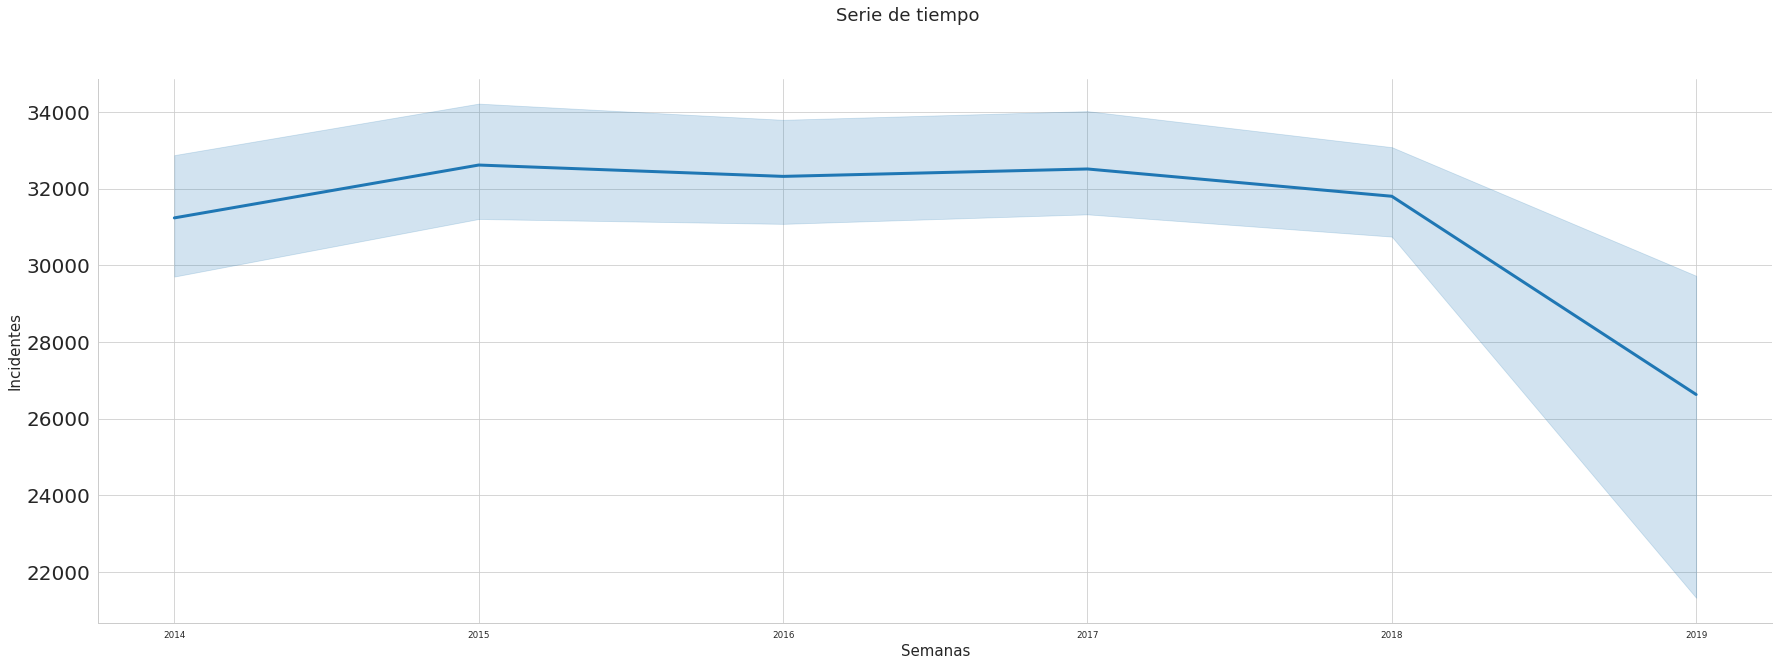

In [287]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=x, x=x.index, y='EVENTS', linewidth = 3)
#sns.scatterplot(data=dfweek, x=dfweek.index, y='COUNT', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
#plt.xticks(x.index(), x.ANIO, fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

NameError: name 'dfp' is not defined

In [22]:
dfweek = data_time_series(1, 100, -74.07745119017216, 4.604447520159951, dfp)
dfweek

,COUNT
NSEM,
1,4
2,4
3,8
4,14
5,11
6,18
7,18
8,8
9,14


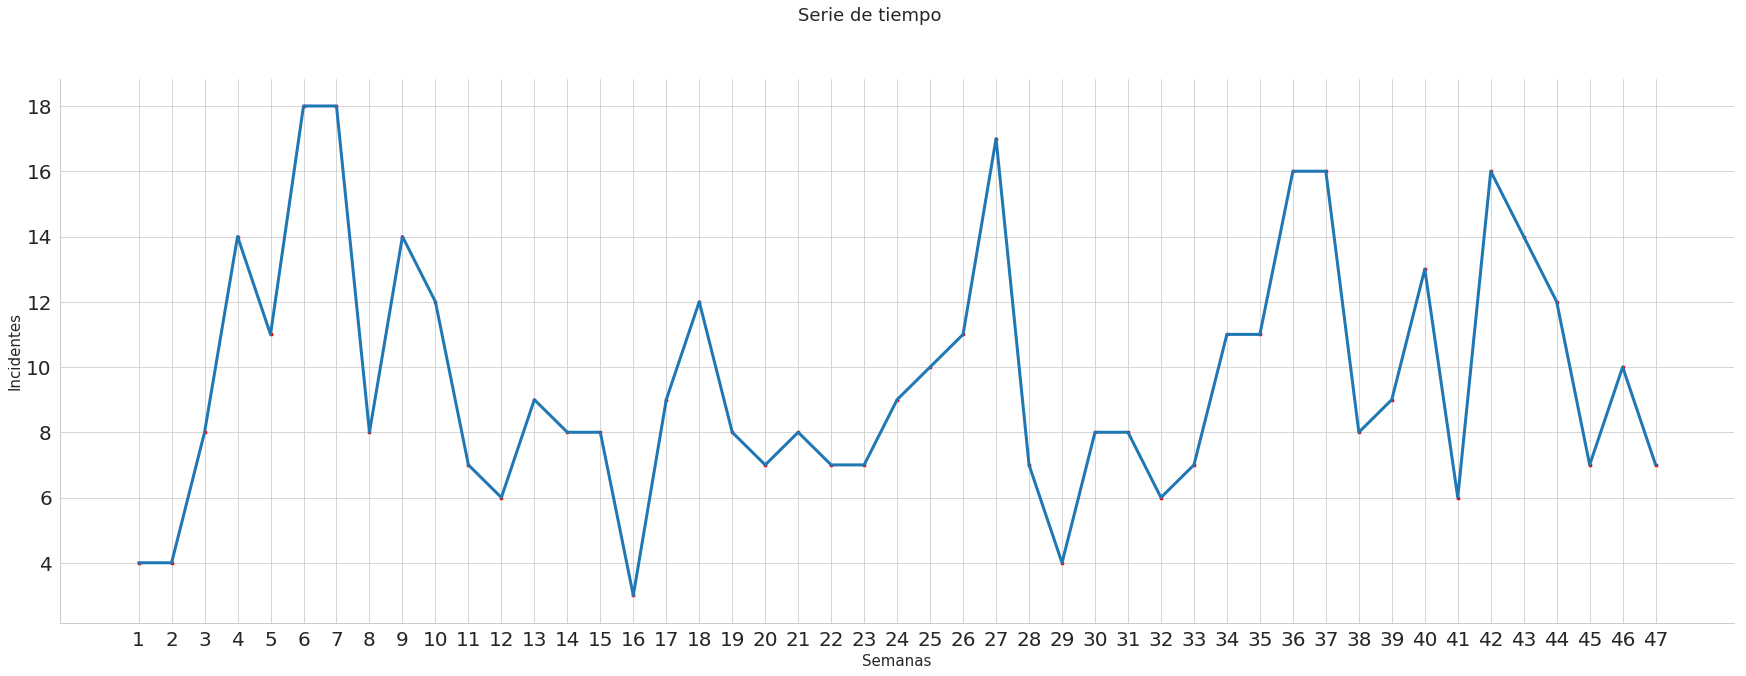

In [113]:
# plot
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize=(30,10))
fig.suptitle('Serie de tiempo')
sns.set_style("whitegrid")
lp = sns.lineplot(data=dfweek, x=dfweek.index, y='COUNT', linewidth = 3)
sns.scatterplot(data=dfweek, x=dfweek.index, y='COUNT', color='red', sizes=40)
lp.set(xlabel='Semanas', ylabel='Incidentes')
plt.xticks(dfweek.index.to_list(), dfweek.index.to_list(), fontsize=20)
plt.yticks(fontsize=20)
sns.despine()
plt.show()

In [432]:
x.groupby(['ANIO']).count().reset_index()

,ANIO,MES,EVENTS
0,2014,12,12
1,2015,12,12
2,2016,12,12
3,2017,12,12
4,2018,12,12
5,2019,12,12


In [530]:
x = data_series(dfp, 3,None, 2, None, None)


In [531]:
x

,ANIO,MES,DIA,DSEM,EVENTS
2,2014,1,1,2,3529.0
9,2014,1,2,2,0.0
16,2014,1,3,2,0.0
23,2014,1,4,2,0.0
30,2014,1,5,2,0.0
...,...,...,...,...,...
15591,2019,12,27,2,0.0
15598,2019,12,28,2,0.0
15605,2019,12,29,2,0.0
15612,2019,12,30,2,0.0


In [443]:
c = 0
l = list()
for i in range (0, 72):  
    if i == c:
        c = c + 12
        l.append('hola')
    else:
        l.append('')

In [445]:
        if tp == 1:
            # indice para todas las semanas
            index = pd.date_range(start=fi, end=ff, freq='W', 
                                  closed="left").strftime('%Y-%m-%d').to_list()
            # agrupando por
            serie = ['ANIO', 'MES', 'NSEM']
            data = {'ANIO': pd.to_datetime(index).year.tolist(),
                    'MES': pd.to_datetime(index).month.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}
            # preparando dataframe de salida
            dfo = pd.DataFrame(index=index, data=data)
            dfo = dfo.sort_values(['ANIO', 'MES', 'NSEM'])
            # generando agrupamiento
            df = df.sort_values(['FECHA'])
            dfi = pd.DataFrame(df.groupby(serie)['UPZ'].count()).reset_index()
            dft = pd.DataFrame()
            i = 0
            iifa = 0
            while(i < len(dfi) - 1):
                # incidentes inicio y final de año que caen en la misma semana
                # se añade a la semana 1
                # ejemplo: si hay días en el mes 12 del 2014 que caen en la semana 1 del
                # siguiente año se añaden a esa primera semana      
                if dfi['NSEM'].iloc[i] == dfi['NSEM'].iloc[i + 1]:
                    
                    row = dfi.iloc[i]
                    row['UPZ'] = int(dfi['UPZ'].iloc[i] + dfi['UPZ'].iloc[i + 1]) 
                    dft = dft.append(row, ignore_index=True)
                    i = i + 2                                      
                else:
                    if (dfi['MES'].iloc[i] == 12 and dfi['NSEM'].iloc[i] == 1) or (dfi['MES'].iloc[i] == 12 and dfi['NSEM'].iloc[i] == 53):
                        iifa = dfi['UPZ'].iloc[i] 
                    else:     
                        if (dfi['MES'].iloc[i] == 1 and dfi['NSEM'].iloc[i] == 1) or (dfi['MES'].iloc[i] == 1 and dfi['NSEM'].iloc[i] == 53):
                            dfi['UPZ'].iloc[i] = dfi['UPZ'].iloc[i] + iifa
                        row = dfi.iloc[i]
                        dft = dft.append(row, ignore_index=True)
                    i = i + 1
            
            dft = dft.astype(int)
            for i in range(len(dft)):
                if (dfo['ANIO'].iloc[i] == dft['ANIO'].iloc[i]) and (dfo['NSEM'].iloc[i] == dft['NSEM'].iloc[i]):
                        dfo['EVENTS'].iloc[i] = dft['UPZ'].iloc[i]  
            
            return dft, dfo
        

72

In [ ]:
 if tp == 1:
            # indice para todas las semanas
            index = pd.date_range(start=fi, end=ff, freq='W', 
                                  closed="left").strftime('%Y-%m-%d')
            # agrupando por
            serie = ['ANIO', 'MES', 'NSEM']
            data = {'ANIO': pd.to_datetime(index).year.tolist(),
                    'NSEM': pd.to_datetime(index).week.tolist(),
                    'EVENTS': np.zeros(len(index), dtype=int)}
            # preparando dataframe de salida
            dfo = pd.DataFrame(index=index.to_list(), data=data)
            ani = int(fi)
            for i in range(len(index)):
                if i == 0:
                    ffi = pd.to_datetime(fi).strftime('%Y-%m-%d')
                    fff = (pd.to_datetime(index[i]) + pd.to_timedelta(1,'d')).strftime('%Y-%m-%d')
                    inc = df[(df['FECHA'] >= ffi) & (df['FECHA'] < fff)]['UPZ'].count()
                    dfo['EVENTS'].iloc[i] = inc
                else:
                    ffi = (pd.to_datetime(index[i - 1]) + pd.to_timedelta(1,'d')).strftime('%Y-%m-%d')
                    fff = (pd.to_datetime(index[i]) + pd.to_timedelta(1,'d')).strftime('%Y-%m-%d')
                    inc = df[(df['FECHA'] >= ffi) & (df['FECHA'] < fff)]['UPZ'].count()
                    dfo['EVENTS'].iloc[i] = inc
            return df